In [22]:
# Imports
import bson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import csr_matrix
import fonctions
import importlib
importlib.reload(fonctions)
from fonctions import *
from surprise import BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import KNNBasic, KNNWithMeans, NMF
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from surprise.model_selection import GridSearchCV
import time

In [23]:



###################################################################################################

# Open and read the BSON files
with open("./trictrac/details.bson", "rb") as f:
    details = bson.decode_all(f.read())


with open("./trictrac/infos_scrapping.bson", "rb") as f:
    infos = bson.decode_all(f.read())

with open("./trictrac/jeux.bson", "rb") as f:
    jeux = bson.decode_all(f.read())


with open("./trictrac/avis.bson", "rb") as f:
    avis = bson.decode_all(f.read())

pdDetails = pd.DataFrame(details)
pdJeux = pd.DataFrame(jeux)
pdInfos = pd.DataFrame(infos)
pdAvis = pd.DataFrame(avis)

###################################################################################################
# Nettoyage

# Spam removable 
pdAvis['review_length'] = pdAvis['comment'].str.len()
pdAvis=pdAvis[pdAvis["review_length"] != 58097.0]

#Duplicates removable
pdAvis.drop_duplicates(subset=['author','title_review','note','title','comment'], inplace=True)
pdJeux.drop_duplicates(subset=['title',	'href','avis'], inplace=True)


allgames = sorted(pdJeux["title"].unique())
allusers = sorted(pdAvis['author'].unique())


# Création de la dataFrame  
ratings_matrix = pd.DataFrame(
    index=allusers,
    columns=allgames,
    dtype=float
)

# Remplissage de la matrice avec les notes
for _, row in pdAvis.iterrows():
    ratings_matrix.at[row['author'], row['title']] = row['note']

# Conversion en matrice sparse
mask = ~ratings_matrix.isna()
sparse_ratings_matrix = csr_matrix(
    (
        ratings_matrix.values[mask], 
        np.where(mask)
    ),
    shape=ratings_matrix.shape
)

# Remove users and games with with low numbers of ratings the optimal value found was (14,18)
from fonctions import minipingpong, subtract_mean
cleaned_matrix, allusers, allgames = minipingpong(sparse_ratings_matrix, allusers, allgames, 14, 18)

###################################################################################################

Initial matrix: 13623 users, 16366 games, 176070 ratings
Iteration 1: 2204 users, 2329 games, 112253 ratings
Converged!
Final matrix: 2204 users, 2329 games, 112253 ratings


# Preproccesing + Baseline models

In [3]:
train_matrix, test_matrix, train_mask, test_mask = custom_train_test_split(
    cleaned_matrix, 
    test_size=0.2, 
    max_user_loss=0.5, 
    max_game_loss=0.5,
) # Masking ratings

test_rows, test_cols = test_matrix.nonzero()
test_ratings = test_matrix.data



train_list = []
for i, j in zip(*train_matrix.nonzero()):
    train_list.append((allusers[i], allgames[j], train_matrix[i, j]))
train_df = pd.DataFrame(train_list, columns=['userID', 'itemID', 'rating'])

test_list = []
for i, j in zip(*test_matrix.nonzero()):
    test_list.append((allusers[i], allgames[j], test_matrix[i, j]))
test_df = pd.DataFrame(test_list, columns=['userID', 'itemID', 'rating'])



###################################################################################################


global_mean, rmse_global, mae_global, r2_global = global_mean_baseline(train_matrix, test_matrix)
user_means, rmse_user, mae_user, r2_user = user_mean_baseline(train_matrix, test_matrix) 
item_means, rmse_game, mae_game, r2_game = item_mean_baseline(train_matrix, test_matrix)


results = pd.DataFrame({
    'Model': ['Global Mean', 'User Mean', 'Game Mean'],
    'RMSE': [rmse_global, rmse_user, rmse_game ],
    'MAE': [mae_global, mae_user, mae_game],
    'R2 score': [r2_global, r2_user, r2_game]
})


Split complete: 22450 ratings (20.00%) in test set
Train set: 89803 ratings, Test set: 22450 ratings
Maximum user ratings loss : 50.00%
Maximum game ratings during the split: 50.00%
Global Mean Baseline: RMSE = 2.0946, MAE = 1.6958
User Mean Baseline: RMSE = 2.1455, MAE = 1.6874
Item Mean Baseline: RMSE = 2.2845, MAE = 1.8111


# Normalizing our dataset by our user mean for surprise

In [4]:
# Compute each user’s mean rating in train only
user_means = train_df.groupby('userID')['rating'].mean().to_dict()
train_norm = normalize_df(train_df, user_means)
test_norm  = normalize_df(test_df,  user_means)

# Surprise needs a DataFrame with columns user, item, rating
reader = Reader(rating_scale=(train_norm['rating_norm'].min(),
                              train_norm['rating_norm'].max()))


data_norm = Dataset.load_from_df(
    train_norm[['userID','itemID','rating_norm']],
    reader
)


# build a Surprise trainset; we’ll manually use test_norm for evaluation and a normal surprise train/test set for our knn test
surprise_trainset = data_norm.build_full_trainset()

reader_knn =  Reader(rating_scale=(0,10))
data = Dataset.load_from_df(train_df, Reader(rating_scale=(0,10)))
trainsetknn, testsetknn = surprise_train_test_split(data, test_size=0.2, random_state=42)



# Training the surprise models (default parameters)

In [5]:
algo_baseline  = BaselineOnly()
algo_svd       = SVD()
algo_nmf       = NMF()
algo_knn_basic = KNNBasic()  #it is equivalent to  KNNWithMeans from Surprise if we substracted the user mean so we will try without substracting the user mean to see what happens if we dont try to mitigate the bias we get with user habits
algo_knn_means = KNNWithMeans()

######################################################################################################
#fit 

algo_baseline.fit(surprise_trainset)
algo_svd.fit(surprise_trainset)
algo_nmf.fit(surprise_trainset)
algo_knn_basic.fit(trainsetknn)
algo_knn_means.fit(trainsetknn)

######################################################################################################
# test
# Build Surprise-style “testset” from your normalized test DataFrame:
#   (uid, iid, true_rating_norm)
testset_norm = list(test_norm[['userID','itemID','rating_norm']].itertuples(index=False, name=None))

# Get predictions
preds_baseline_norm = algo_baseline.test(testset_norm)
preds_svd_norm      = algo_svd.test(testset_norm)
preds_nmf_norm = algo_nmf.test(testset_norm)
preds_basic_norm = algo_knn_basic.test(testsetknn)
preds_means_norm = algo_knn_means.test(testsetknn)


######################################################################################################
denorm_baseline = denormalize(preds_baseline_norm, user_means)
denorm_svd      = denormalize(preds_svd_norm,      user_means)
denorm_svd      = denormalize(preds_svd_norm,      user_means)
denorm_nmf      = denormalize(preds_nmf_norm,      user_means)




metrics = {}
for name, denorm in [
    ('BaselineOnly (Surprise)', denorm_baseline),
    ('SVD (Surprise)',          denorm_svd),
    ('NMF (Surprise)',          denorm_nmf),
    ('KNNBasic (Surprise)',     preds_basic_norm),
    ('KNNWithMeans (Surprise)', preds_means_norm),
]:
    y_true, y_pred = unpack(denorm)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    metrics[name] = (rmse, mae, r2)

######################################################################################################
new_rows = []
for name, (rmse, mae, r2) in metrics.items():
    new_rows.append({
        'Model':     name,
        'RMSE':      rmse,
        'MAE':       mae,
        'R2 score':  r2
    })

results = pd.concat([results, pd.DataFrame(new_rows)], ignore_index=True)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


# Trying with a Knn from sklearn 

In [6]:
normalized_matrix = subtract_mean(cleaned_matrix)

# Apply sklearn KNN to the normalized data
train_matrixN_coo = train_matrix.tocoo()
train_users = train_matrixN_coo.row
train_items = train_matrixN_coo.col
train_ratings = train_matrixN_coo.data

######################################################################################################
X_train = np.column_stack((train_users, train_items))
y_train = train_ratings 

# Get test data in the right format
test_matrixN_coo = test_matrix.tocoo()
test_users = test_matrixN_coo.row
test_items = test_matrixN_coo.col
test_ratings = test_matrixN_coo.data

# Create feature vectors for testing
X_test = np.column_stack((test_users, test_items))

######################################################################################################
# Get user means (needed to revert normalization)
data_array = cleaned_matrix.toarray()
user_means_array = np.zeros(data_array.shape[0])
for i in range(data_array.shape[0]):
    user_ratings = data_array[i, :]
    non_zero_indices = user_ratings != 0
    if non_zero_indices.any():
        user_means_array[i] = user_ratings[non_zero_indices].mean()
 
knn = KNeighborsRegressor(n_neighbors=40, weights='distance')
knn.fit(X_train, y_train)

# Generate predictions (still normalized)
y_pred_normalized = knn.predict(X_test)

# Revert the normalization to get actual predictions
y_pred = y_pred_normalized + np.array([user_means_array[user] for user in test_users])

# Revert the normalization for test data too
y_test_actual = test_ratings + np.array([user_means_array[user] for user in test_users])


######################################################################################################
rmse_sklearn = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae_sklearn = mean_absolute_error(y_test_actual, y_pred)
r2_sklearn = r2_score(y_test_actual, y_pred)

sklearn_results = pd.DataFrame({
    'Model': ['KNeighborsRegressor (Sklearn)'],
    'RMSE': [rmse_sklearn],
    'MAE': [mae_sklearn],
    'R2 score': [r2_sklearn]
})


results = pd.concat([results, sklearn_results], ignore_index=True)

# Model comparison with the base parameters

In [7]:

print("All Model Comparison:")
print(results.to_string(index=False))

# Calculate rankings for each model across metrics
# For RMSE, MAE, MSE: lower is better
# For R2: higher is better
rmse_rank = results['RMSE'].rank()
mae_rank = results['MAE'].rank()
r2_rank = results['R2 score'].rank(ascending=False)  # Reversed for R2

results['RMSE Rank'] = rmse_rank
results['MAE Rank'] = mae_rank
results['R2 Rank'] = r2_rank

# Calculate average rank across all metrics
results['Avg Rank'] = (rmse_rank + mae_rank + r2_rank) / 3
ranked_results = results.sort_values('Avg Rank')


print("\nModel Rankings :")
print(ranked_results[['Model', 'RMSE Rank', 'MAE Rank','R2 Rank', 'Avg Rank']].to_string(index=False))

best_rmse = results.loc[results['RMSE'].idxmin()]
best_mae = results.loc[results['MAE'].idxmin()]
best_r2 = results.loc[results['R2 score'].idxmax()]

# Find overall best model 
best_overall = ranked_results.iloc[0]

print("\nBest Models By Metric:")
print(f"Best RMSE: {best_rmse['Model']} ({best_rmse['RMSE']:.4f})")
print(f"Best MAE: {best_mae['Model']} ({best_mae['MAE']:.4f})")
print(f"Best R²: {best_r2['Model']} ({best_r2['R2 score']:.4f})")
print(f"\nBest Overall Model: {best_overall['Model']} (Average Rank: {best_overall['Avg Rank']:.2f})")

All Model Comparison:
                        Model     RMSE      MAE  R2 score
                  Global Mean 2.094553 1.695836  0.000000
                    User Mean 2.145450 1.687382 -5.805758
                    Game Mean 2.284490 1.811062 -4.552234
      BaselineOnly (Surprise) 1.776524 1.361199  0.269517
               SVD (Surprise) 1.831236 1.399024  0.223831
               NMF (Surprise) 2.347410 1.736385 -0.275399
          KNNBasic (Surprise) 1.902810 1.480411  0.162418
      KNNWithMeans (Surprise) 1.831623 1.405063  0.223916
KNeighborsRegressor (Sklearn) 2.088593 1.665967  0.314954

Model Rankings :
                        Model  RMSE Rank  MAE Rank  R2 Rank  Avg Rank
      BaselineOnly (Surprise)        1.0       1.0      2.0  1.333333
               SVD (Surprise)        2.0       2.0      4.0  2.666667
      KNNWithMeans (Surprise)        3.0       3.0      3.0  3.000000
KNeighborsRegressor (Sklearn)        5.0       5.0      1.0  3.666667
          KNNBasic (Surprise) 

# Finding the best parameters for BaselineOnly,KNNWithMeans and NMF

In [8]:

best_configs = {}
all_best_models = []

# models param to test
param_grid_baseline = {
    'bsl_options': {
        'reg': [0.001, 0.01, 0.02, 0.05, 0.1, 0.2],
        'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05]
    }
}
param_grid_knn = {
    'k': [5, 10, 20, 30, 40, 50, 60, 65, 70, 80,85, 90, 100, 110, 120],
}

param_grid_nmf = {
    'n_factors': [10, 15, 20, 25, 30, 40, 50, 65, 75],
    'biased':    [True],
    'reg_pu':    [0.02, 0.05, 0.1],
    'reg_qi':    [0.02, 0.05, 0.1],
}

######################################################################################################


gs_baseline = GridSearchCV(BaselineOnly, param_grid_baseline, measures=['rmse', 'mae'], cv=3)
gs_baseline.fit(data)

best_baseline_params = gs_baseline.best_params['rmse']
best_baseline_score = gs_baseline.best_score['rmse']
print(f"\nBaselineOnly Best Parameters: {best_baseline_params}")
print(f"RMSE: {best_baseline_score:.4f}")

results_baseline = []
for params, mean_rmse, mean_mae in zip(
        gs_baseline.cv_results['params'],
        gs_baseline.cv_results['mean_test_rmse'],
        gs_baseline.cv_results['mean_test_mae']):
    results_baseline.append({'params': params, 'mean_test_rmse': mean_rmse, 'mean_test_mae': mean_mae})
results_baseline.sort(key=lambda x: x['mean_test_rmse'])
print_grid_search_results(results_baseline)

best_configs['BaselineOnly'] = best_baseline_params

######################################################################################################


gs_knn = GridSearchCV(KNNWithMeans, param_grid_knn, measures=['rmse', 'mae'], cv=3)
gs_knn.fit(data)

best_knn_params = gs_knn.best_params['rmse']
best_knn_score = gs_knn.best_score['rmse']
print(f"\nKNNWithMeans Best Parameters: {best_knn_params}")
print(f"RMSE: {best_knn_score:.4f}")

results_knn = []
for params, mean_rmse, mean_mae in zip(
        gs_knn.cv_results['params'],
        gs_knn.cv_results['mean_test_rmse'],
        gs_knn.cv_results['mean_test_mae']):
    results_knn.append({'params': params, 'mean_test_rmse': mean_rmse, 'mean_test_mae': mean_mae})
results_knn.sort(key=lambda x: x['mean_test_rmse'])
print_grid_search_results(results_knn)

best_configs['KNNWithMeans'] = best_knn_params

######################################################################################################

# First, perform grid search on normalized data (to match final usage)
data_norm_full = Dataset.load_from_df(
    train_norm[['userID','itemID','rating_norm']],
    reader
)

gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mae'], cv=3)
gs_nmf.fit(data_norm_full)  # Use normalized data for grid search

# Get the best parameters
best_nmf_params = gs_nmf.best_params['rmse']
best_nmf_score = gs_nmf.best_score['rmse']

print(f"\nNMF Best Parameters: {best_nmf_params}")
print(f"CV RMSE: {best_nmf_score:.4f}")

# Store the best parameters in the configs dictionary
best_configs['NMF'] = best_nmf_params

# Print grid search results for review
results_nmf = []
for params, mean_rmse, mean_mae in zip(
    gs_nmf.cv_results['params'],
    gs_nmf.cv_results['mean_test_rmse'],
    gs_nmf.cv_results['mean_test_mae']
):
    results_nmf.append({
        'params': params,
        'mean_test_rmse': mean_rmse,
        'mean_test_mae': mean_mae
    })
results_nmf.sort(key=lambda x: x['mean_test_rmse'])


print_grid_search_results(results_nmf)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [9]:
######################################################################################################


param_grid_svd = {
    "n_factors": [50, 100, 150],        # Number of factors
    "n_epochs": [20, 30],             # Number of iterations
    "lr_all": [0.002, 0.005, 0.01],   # Learning rate
    "reg_all": [0.02, 0.05, 0.1],    # Regularization term
    "biased": [True]                  # Use biases (usually standard for SVD)
}


gs_svd = GridSearchCV(SVD, param_grid_svd, measures=["rmse", "mae"], cv=3, n_jobs=-1)


gs_svd.fit(data)



# Get the best parameters
best_svd_params = gs_svd.best_params['rmse']
best_svd_score = gs_svd.best_score['rmse']

print(f"\nNMF Best Parameters: {best_svd_params}")
print(f"CV RMSE: {best_svd_score:.4f}")

# Store the best parameters in the configs dictionary
best_configs['SVD'] = best_svd_params

# Print grid search results for review
results_svd = []
for params, mean_rmse, mean_mae in zip(
    gs_svd.cv_results['params'],
    gs_svd.cv_results['mean_test_rmse'],
    gs_svd.cv_results['mean_test_mae']
):
    results_svd.append({
        'params': params,
        'mean_test_rmse': mean_rmse,
        'mean_test_mae': mean_mae
    })
results_svd.sort(key=lambda x: x['mean_test_rmse'])


print_grid_search_results(results_svd)




NMF Best Parameters: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'biased': True}
CV RMSE: 1.7988
Top 5 parameter combinations:
1. {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'biased': True} - RMSE: 1.7988
2. {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'biased': True} - RMSE: 1.8048
3. {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.1, 'biased': True} - RMSE: 1.8065
4. {'n_factors': 150, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1, 'biased': True} - RMSE: 1.8071
5. {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.05, 'biased': True} - RMSE: 1.8074


In [10]:
best_baseline = BaselineOnly(**best_configs['BaselineOnly'])
best_knn = KNNWithMeans(**best_configs['KNNWithMeans'])
best_nmf = NMF(**best_configs['NMF'])
best_svd = SVD(**best_configs['SVD'])

optimized_results = []

best_baseline.fit(surprise_trainset)
best_nmf.fit(trainsetknn) 
# Use trainsetknn for KNNWithMeans to avoid division by zero, also with nmf because we found biased in the optimal to be true so no need to apply the normalized set
best_knn.fit(trainsetknn)
best_svd.fit(trainsetknn)

baseline_predictions = best_baseline.test(testset_norm)
nmf_predictions = best_nmf.test(testsetknn)
knn_predictions = best_knn.test(testsetknn)  # Use testsetknn for KNN
svd_predictions = best_svd.test(testsetknn)


denorm_baseline = denormalize(baseline_predictions, user_means)

for name, denorm in [
    ('BaselineOnly (Optimized)', denorm_baseline),
]:
    y_true, y_pred = unpack(denorm)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    optimized_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2 score': r2
    })

# KNNWithMeans (already using non-normalized data)
y_true, y_pred = unpack(knn_predictions)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)


optimized_results.append({
    'Model': 'KNNWithMeans (Optimized)',
    'RMSE': rmse,
    'MAE': mae, 
    'R2 score': r2
})

# NMF
y_true_nmf, y_pred_nmf = unpack(nmf_predictions)
rmse_nmf = np.sqrt(mean_squared_error(y_true_nmf, y_pred_nmf))
mae_nmf = mean_absolute_error(y_true_nmf, y_pred_nmf)
r2_nmf = r2_score(y_true_nmf, y_pred_nmf)
optimized_results.append({
    'Model': 'NMF (Optimized)', 'RMSE': rmse_nmf, 'MAE': mae_nmf, 'R2 score': r2_nmf
})

#SVD 

y_true_svd, y_pred_svd = unpack(svd_predictions)
rmse_svd = np.sqrt(mean_squared_error(y_true_svd, y_pred_svd))
mae_svd = mean_absolute_error(y_true_svd, y_pred_svd)
r2_svd = r2_score(y_true_svd, y_pred_svd)
optimized_results.append({
    'Model': 'SVD (Optimized)', 'RMSE': rmse_svd, 'MAE': mae_svd, 'R2 score': r2_svd
})

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [11]:
optimized_df = pd.DataFrame(optimized_results)
comparison_results = pd.concat([results, optimized_df], ignore_index=True)

print("\nComparison of all models (original vs. optimized):")
print(comparison_results[['Model', 'RMSE', 'MAE', 'R2 score']])


rmse_rank = comparison_results['RMSE'].rank()
mae_rank = comparison_results['MAE'].rank()

r2_rank = comparison_results['R2 score'].rank(ascending=False)  # Reversed for R2

comparison_results['RMSE Rank'] = rmse_rank
comparison_results['MAE Rank'] = mae_rank
comparison_results['R2 Rank'] = r2_rank
comparison_results['Avg Rank'] = (rmse_rank + mae_rank + r2_rank) / 3

ranked_final = comparison_results.sort_values('Avg Rank')
print("\nFinal Model Rankings (including optimized models):")
print(ranked_final[['Model', 'RMSE Rank', 'MAE Rank', 'R2 Rank', 'Avg Rank']])


best_final = ranked_final.iloc[0]
print(f"\nBest Overall Model: {best_final['Model']} (Average Rank: {best_final['Avg Rank']:.2f})")


Comparison of all models (original vs. optimized):
                            Model      RMSE       MAE  R2 score
0                     Global Mean  2.094553  1.695836  0.000000
1                       User Mean  2.145450  1.687382 -5.805758
2                       Game Mean  2.284490  1.811062 -4.552234
3         BaselineOnly (Surprise)  1.776524  1.361199  0.269517
4                  SVD (Surprise)  1.831236  1.399024  0.223831
5                  NMF (Surprise)  2.347410  1.736385 -0.275399
6             KNNBasic (Surprise)  1.902810  1.480411  0.162418
7         KNNWithMeans (Surprise)  1.831623  1.405063  0.223916
8   KNeighborsRegressor (Sklearn)  2.088593  1.665967  0.314954
9        BaselineOnly (Optimized)  1.776524  1.361199  0.269517
10       KNNWithMeans (Optimized)  1.828207  1.402307  0.226808
11                NMF (Optimized)  1.791686  1.372234  0.257391
12                SVD (Optimized)  1.775551  1.373629  0.270705

Final Model Rankings (including optimized models):


# Error analysis

In [12]:
preds_df_baseline = predictions_to_df(denorm_baseline)
preds_df_knn = predictions_to_df(knn_predictions)
preds_df_nmf = predictions_to_df(nmf_predictions)
preds_df_svd = predictions_to_df(svd_predictions) 

all_preds_dfs = {
    'BaselineOnly': preds_df_baseline,
    'KNNWithMeans': preds_df_knn,
    'NMF': preds_df_nmf,
    'SVD': preds_df_svd
}

for name, df in all_preds_dfs.items():
    df['model'] = name
    df['abs_error'] = abs(df['true_rating'] - df['predicted_rating'])

# Combine into one large DataFrame for easier analysis
combined_preds_df = pd.concat(all_preds_dfs.values(), ignore_index=True)

print(f"Created combined DataFrame with {len(combined_preds_df)} predictions.")
print(combined_preds_df.head())
print("\nError summary per model:")
print(combined_preds_df.groupby('model')['abs_error'].describe())

Created combined DataFrame with 76256 predictions.
             userID                                itemID  true_rating  \
0  *FitzChevalerie*                           Archipelago         10.0   
1        --- JD ---  Android: Netrunner - Das Kartenspiel          9.9   
2        --- JD ---                     Arctic Scavengers          7.7   
3        --- JD ---                           Black Fleet          6.8   
4        --- JD ---             Blood Bowl : Team Manager          7.4   

   predicted_rating         model  abs_error  
0          8.707655  BaselineOnly   1.292345  
1          8.121644  BaselineOnly   1.778356  
2          7.136060  BaselineOnly   0.563940  
3          6.755087  BaselineOnly   0.044913  
4          7.572612  BaselineOnly   0.172612  

Error summary per model:
                count      mean       std  min       25%       50%       75%  \
model                                                                          
BaselineOnly  22421.0  1.361199  1.1

In [13]:


#nCalculating user and item statistics from train_df

# Item statistics (popularity = number of ratings)
item_stats = train_df.groupby('itemID').agg(
    item_n_ratings=('rating', 'count'),
    item_mean_rating=('rating', 'mean')
).reset_index()

# User statistics (activity = number of ratings)
user_stats = train_df.groupby('userID').agg(
    user_n_ratings=('rating', 'count'),
    user_mean_rating=('rating', 'mean')
).reset_index()

print(f"Calculated stats for {len(item_stats)} items and {len(user_stats)} users.")
print("\nItem Stats Head:")
print(item_stats.head())
print("\nUser Stats Head:")
print(user_stats.head())

Calculated stats for 2329 items and 2204 users.

Item Stats Head:
                                          itemID  item_n_ratings  \
0                                    10' to kill              75   
1  13 jours, la crise des missiles de Cuba, 1962              15   
2                1775 - la révolution américaine              26   
3                    1812 - L'Invasion du Canada              25   
4                       1944 : Race to the Rhine              12   

   item_mean_rating  
0          7.612000  
1          8.293333  
2          8.603846  
3          8.652000  
4          8.841667  

User Stats Head:
             userID  user_n_ratings  user_mean_rating
0  *FitzChevalerie*              14          8.507143
1        --- JD ---             251          7.170518
2            20.100              20          7.900000
3             20cil              19          6.421053
4           26vince              32          8.843750


In [14]:

print("\nMerging predictions with item and user stats...")

merged_df = pd.merge(combined_preds_df, item_stats, on='itemID', how='left')

merged_df = pd.merge(merged_df, user_stats, on='userID', how='left')

# Handle potential NaNs if items/users in test set weren't in train set (unlikely)
merged_df.fillna({'item_n_ratings': 0, 'item_mean_rating': train_df['rating'].mean(), # Impute with global mean
                  'user_n_ratings': 0, 'user_mean_rating': train_df['rating'].mean()}, inplace=True)


merged_df.head()


Merging predictions with item and user stats...


,userID,itemID,true_rating,predicted_rating,model,abs_error,item_n_ratings,item_mean_rating,user_n_ratings,user_mean_rating
0,*FitzChevalerie*,Archipelago,10.0,8.707655,BaselineOnly,1.292345,106,7.987736,14,8.507143
1,--- JD ---,Android: Netrunner - Das Kartenspiel,9.9,8.121644,BaselineOnly,1.778356,57,8.694737,251,7.170518
2,--- JD ---,Arctic Scavengers,7.7,7.136060,BaselineOnly,0.563940,42,7.454762,251,7.170518
3,--- JD ---,Black Fleet,6.8,6.755087,BaselineOnly,0.044913,86,7.082558,251,7.170518
4,--- JD ---,Blood Bowl : Team Manager,7.4,7.572612,BaselineOnly,0.172612,59,8.076271,251,7.170518


### Analyzing error vs. Item Popularity

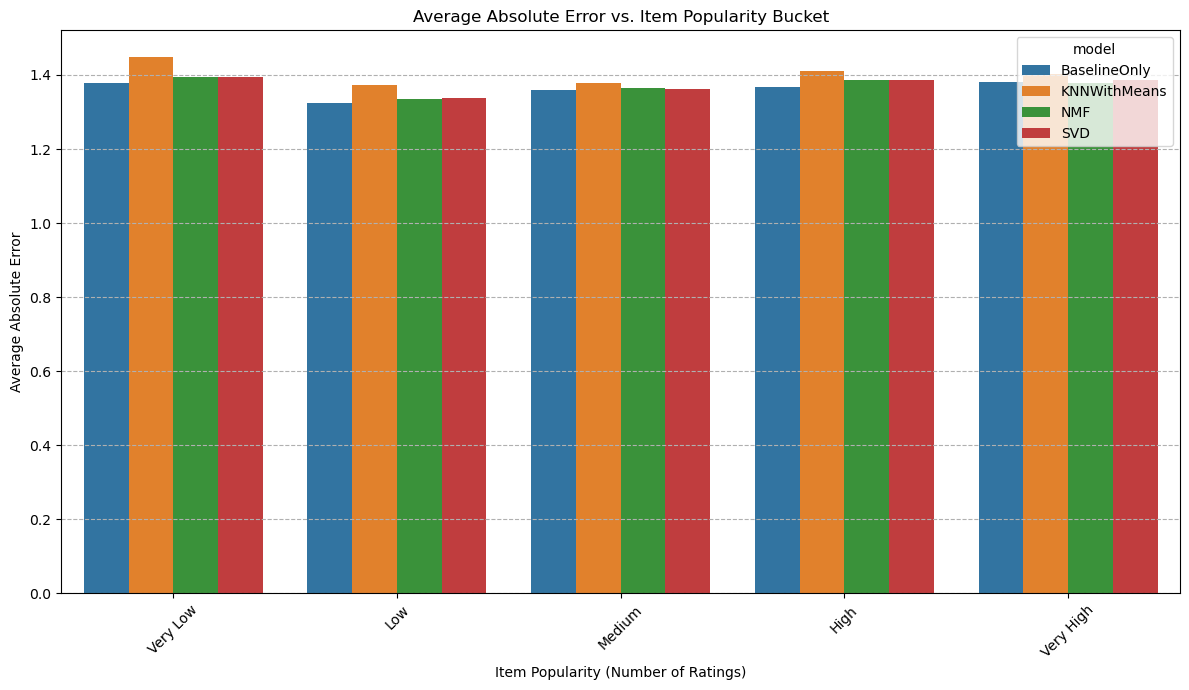


Error by Item Popularity:
model                  BaselineOnly  KNNWithMeans       NMF       SVD
item_pop_bucket_label                                                
High                       1.366835      1.409372  1.387606  1.387164
Low                        1.323109      1.373394  1.335151  1.337810
Medium                     1.358521      1.377541  1.365274  1.362124
Very High                  1.380195      1.403395  1.377967  1.385883
Very Low                   1.377422      1.448123  1.395093  1.395113


In [15]:


try:
    merged_df['item_pop_bucket'] = pd.qcut(merged_df['item_n_ratings'], q=5, labels=False, duplicates='drop')
    bucket_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High'] # Adjust if fewer than 5 buckets created
    unique_buckets = sorted(merged_df['item_pop_bucket'].unique())
    label_map = {i: bucket_labels[i] for i in unique_buckets if i < len(bucket_labels)}
    merged_df['item_pop_bucket_label'] = merged_df['item_pop_bucket'].map(label_map).fillna('Unknown')

except ValueError as e:
    print(f"Could not create 5 quantile buckets for item popularity, likely due to data distribution: {e}")
    merged_df['item_pop_bucket_label'] = pd.cut(merged_df['item_n_ratings'], bins=3, labels=['Low', 'Medium', 'High'])


# Calculate average absolute error per model and popularity bucket
error_by_item_pop = merged_df.groupby(['model', 'item_pop_bucket_label'])['abs_error'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(data=error_by_item_pop, x='item_pop_bucket_label', y='abs_error', hue='model',
            order=['Very Low', 'Low', 'Medium', 'High', 'Very High'] if 'Very Low' in error_by_item_pop['item_pop_bucket_label'].unique() else ['Low', 'Medium', 'High']) # Ensure correct order
plt.title('Average Absolute Error vs. Item Popularity Bucket')
plt.xlabel('Item Popularity (Number of Ratings)')
plt.ylabel('Average Absolute Error')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("\nError by Item Popularity:")
print(error_by_item_pop.pivot(index='item_pop_bucket_label', columns='model', values='abs_error'))

### Analyzing error vs. User Activity

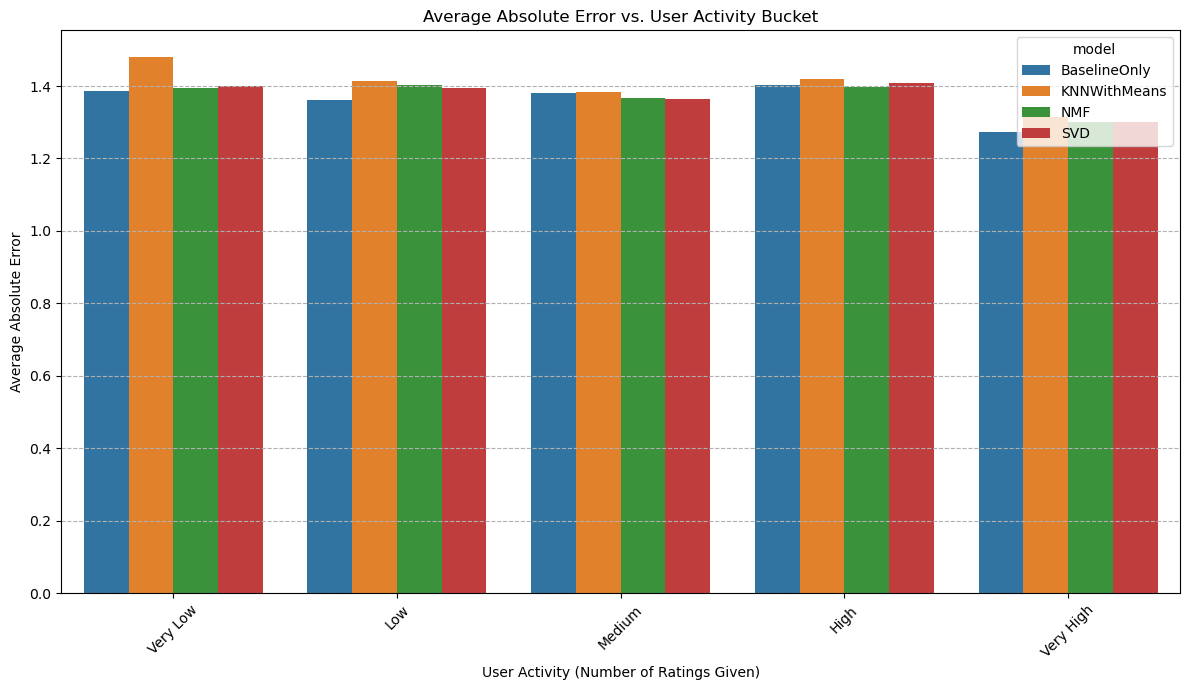


Error by User Activity:
model                  BaselineOnly  KNNWithMeans       NMF       SVD
user_act_bucket_label                                                
High                       1.401932      1.419696  1.398118  1.409321
Low                        1.362481      1.414073  1.401896  1.393202
Medium                     1.380025      1.384590  1.366397  1.365522
Very High                  1.273512      1.315587  1.300983  1.301879
Very Low                   1.385511      1.479679  1.394836  1.399296


In [16]:


try:
    merged_df['user_act_bucket'] = pd.qcut(merged_df['user_n_ratings'], q=5, labels=False, duplicates='drop')
    bucket_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    unique_buckets = sorted(merged_df['user_act_bucket'].unique())
    label_map = {i: bucket_labels[i] for i in unique_buckets if i < len(bucket_labels)}
    merged_df['user_act_bucket_label'] = merged_df['user_act_bucket'].map(label_map).fillna('Unknown')

except ValueError as e:
    print(f"Could not create 5 quantile buckets for user activity: {e}")
    merged_df['user_act_bucket_label'] = pd.cut(merged_df['user_n_ratings'], bins=3, labels=['Low', 'Medium', 'High'])


error_by_user_act = merged_df.groupby(['model', 'user_act_bucket_label'])['abs_error'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(data=error_by_user_act, x='user_act_bucket_label', y='abs_error', hue='model',
            order=['Very Low', 'Low', 'Medium', 'High', 'Very High'] if 'Very Low' in error_by_user_act['user_act_bucket_label'].unique() else ['Low', 'Medium', 'High'])
plt.title('Average Absolute Error vs. User Activity Bucket')
plt.xlabel('User Activity (Number of Ratings Given)')
plt.ylabel('Average Absolute Error')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("\nError by User Activity:")
print(error_by_user_act.pivot(index='user_act_bucket_label', columns='model', values='abs_error'))

### Investigating Largest Errors per Model

In [17]:
n_largest_errors_to_show = 10 # Show top 10 largest errors

for model_name in merged_df['model'].unique():
    print(f"\n--- Largest Errors for Model: {model_name} ---")
    
    # Filter for the current model and sort by absolute error
    model_errors_df = merged_df[merged_df['model'] == model_name].sort_values(by='abs_error', ascending=False)
    
    # Display the top N largest errors

    top_errors_display = model_errors_df.head(n_largest_errors_to_show)[[
        'userID', 'itemID', 
        'true_rating', 'predicted_rating', 'abs_error',
        'user_n_ratings', 'user_mean_rating', 
        'item_n_ratings', 'item_mean_rating'
    ]]
    print(top_errors_display.to_string()) # .to_string() helps print full DataFrame content




--- Largest Errors for Model: BaselineOnly ---
                   userID                itemID  true_rating  predicted_rating  abs_error  user_n_ratings  user_mean_rating  item_n_ratings  item_mean_rating
12033        XavierDESIGN              Crossing          0.3          8.893010   8.593010              16          9.412500              91          6.859341
5382   Jerôme D'entrelacs        Photosynthesis          1.0          9.317667   8.317667               6          9.333333              28          7.842857
16810             l'homme  Battlestar Galactica          0.1          8.380834   8.280834              35          7.591429             125          8.360000
5876            KiwiToast           Serenissima          0.2          8.387998   8.187998              56          7.701786             118          8.353390
22375           zombywoof            Dice Forge          0.5          8.569792   8.069792              73          8.542466             101          7.982178
2191

Investigating largest underestimations per model

In [18]:
n_largest_errors_to_show = 10
MIN_TRUE_RATING_FOR_UNDERESTIMATION_ANALYSIS = 7.0 
for model_name in merged_df['model'].unique():
    print(f"\n--- Largest Underestimations for Model: {model_name} ---")
    
    model_specific_df = merged_df[merged_df['model'] == model_name].copy() 
    
    model_specific_df['underestimation_error'] = model_specific_df['true_rating'] - model_specific_df['predicted_rating']
    

    underestimation_errors_df = model_specific_df[
        (model_specific_df['true_rating'] >= MIN_TRUE_RATING_FOR_UNDERESTIMATION_ANALYSIS) &
        (model_specific_df['predicted_rating'] < model_specific_df['true_rating']) # Ensure it's an underestimation
    ].sort_values(by='underestimation_error', ascending=False) # Sort by how much it was underestimated

    top_underestimations_display = underestimation_errors_df.head(n_largest_errors_to_show)[[
        'userID', 'itemID', 
        'true_rating', 'predicted_rating', 'abs_error', 'underestimation_error',
        'user_n_ratings', 'user_mean_rating', 
        'item_n_ratings', 'item_mean_rating'
    ]]
    if top_underestimations_display.empty:
        print("No significant underestimations found for this model with the current criteria.")
    else:
        print(top_underestimations_display.to_string())


--- Largest Underestimations for Model: BaselineOnly ---
             userID                           itemID  true_rating  predicted_rating  abs_error  underestimation_error  user_n_ratings  user_mean_rating  item_n_ratings  item_mean_rating
15513      glouglou                          Fantasy         10.0          4.327523   5.672477               5.672477             278          6.920863             120          4.500833
20441         rugal                          Wiz-War         10.0          4.686580   5.313420               5.313420              32          4.265625              33          8.263636
12451  _boreale_Tmp                             Toru         10.0          4.770634   5.229366               5.229366              18          6.444444              15          4.140000
6177        Lambour               Um Ru(h)m und Ehre         10.0          4.791755   5.208245               5.208245              31          4.838710              32          7.290625
21819       

### Creating a simple UI to display recommendations based on user
- All recommendations are made on games the user hasnt rated yet
- This function figures out which games a specific user might like or dislike, based on a chosen prediction model we've already trained.
- Then, for each top recommended game, it checks if these 'neighbors' actually rated that specific game highly (e.g., above 6/10). If so, it generates an explanation like: Liked by similar users: UserA (rated 8.0), UserB (rated 7.5). Similarly, for the least recommended games. If it can't find strong like/dislike evidence from neighbors for a particular game, it gives a more general explanation based on overall taste similarity.

In [19]:
# Thresholds and limits
POSITIVE_RATING_THRESHOLD = 6.0 
NEGATIVE_RATING_THRESHOLD = 4.0 
MAX_NEIGHBORS_TO_CITE = 3

def get_recommendations(username, model, all_games, ratings_df, user_means_map=None, n=5, trainset=None):
    """
    Generates top-N and bottom-N game recommendations for a user,
    with KNN explanations for both if possible.
    """
    if username not in ratings_df['author'].unique():
        print(f"Error: Username '{username}' not found in ratings data.")
        return None, None

    rated_games = set(ratings_df[ratings_df['author'] == username]['title'])
    unrated_games = [game for game in all_games if game not in rated_games] # Users unrated and rated games

    if not unrated_games:
        print(f"User '{username}' has rated all available games!") 
        return [], []

    predictions = []
    user_mean = user_means_map.get(username, 0) if user_means_map else 0

    print(f"Predicting ratings for {len(unrated_games)} games for user '{username}'...")
    for game_title in unrated_games:
        pred = model.predict(uid=username, iid=game_title)
        predicted_rating = pred.est
        if user_means_map:
            predicted_rating += user_mean
            predicted_rating = np.clip(predicted_rating, 0, 10)
        predictions.append((game_title, predicted_rating))

    # Sorting
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n_recs = predictions[:n]

    bottom_n_recs = sorted(predictions, key=lambda x: x[1])[:n]

    top_n_recs_final = []
    bottom_n_recs_final = [] 
    generate_explanations = isinstance(model, KNNWithMeans) and trainset is not None
    neighbor_raw_uids = []

    if generate_explanations:
        try:
            user_inner_id = trainset.to_inner_uid(username)
            k_neighbors = model.k
            user_neighbors_inner_ids = model.get_neighbors(user_inner_id, k=k_neighbors)
            neighbor_raw_uids = [trainset.to_raw_uid(inner_id) for inner_id in user_neighbors_inner_ids]
            print(f"Found {len(neighbor_raw_uids)} neighbors for {username}.")
        except ValueError:
            print(f"Warning: User '{username}' not found in the provided trainset. Cannot generate KNN explanations.")
            generate_explanations = False
        except Exception as e:
            print(f"Error getting neighbors: {e}. Cannot generate KNN explanations.")
            generate_explanations = False

    for game_title, rating in top_n_recs:
        explanation_str = None
        if generate_explanations and neighbor_raw_uids:
            try:
                neighbor_ratings_pos = ratings_df[
                    (ratings_df['author'].isin(neighbor_raw_uids)) &
                    (ratings_df['title'] == game_title) &
                    (ratings_df['note'] >= POSITIVE_RATING_THRESHOLD)
                ].sort_values('note', ascending=False)

                if not neighbor_ratings_pos.empty:
                    explanation_parts = []
                    for i in range(min(len(neighbor_ratings_pos), MAX_NEIGHBORS_TO_CITE)):
                        neighbor_name = neighbor_ratings_pos.iloc[i]['author']
                        neighbor_rating = neighbor_ratings_pos.iloc[i]['note']
                        explanation_parts.append(f"{neighbor_name} (rated {neighbor_rating:.1f})")
                    explanation_str = f"Liked by similar users: {'; '.join(explanation_parts)}"
                else:
                    # Fallback for positive
                    cited_neighbors = neighbor_raw_uids[:MAX_NEIGHBORS_TO_CITE]
                    explanation_str = f"Recommended based on taste similarity to: {', '.join(cited_neighbors)}."

            except Exception as e:
                print(f"Error generating positive explanation for '{game_title}': {e}")
                explanation_str = "Explanation generation error."

        top_n_recs_final.append((game_title, rating, explanation_str))

    for game_title, rating in bottom_n_recs:
        explanation_str = None
        if generate_explanations and neighbor_raw_uids:
            try:
                # Find neighbors who rated negatively
                neighbor_ratings_neg = ratings_df[
                    (ratings_df['author'].isin(neighbor_raw_uids)) &
                    (ratings_df['title'] == game_title) &
                    (ratings_df['note'] <= NEGATIVE_RATING_THRESHOLD) # Use less than or equal
                ].sort_values('note', ascending=True) # Sort lowest first

                if not neighbor_ratings_neg.empty:
                    # Create detailed negative explanation
                    explanation_parts = []
                    for i in range(min(len(neighbor_ratings_neg), MAX_NEIGHBORS_TO_CITE)):
                        neighbor_name = neighbor_ratings_neg.iloc[i]['author']
                        neighbor_rating = neighbor_ratings_neg.iloc[i]['note']
                        explanation_parts.append(f"{neighbor_name} (rated {neighbor_rating:.1f})")
                    explanation_str = f"Disliked by similar users: {'; '.join(explanation_parts)}"
                else:
                    # Fallback for negative
                    cited_neighbors = neighbor_raw_uids[:MAX_NEIGHBORS_TO_CITE]
                    explanation_str = f"Low rating predicted based on taste similarity to: {', '.join(cited_neighbors)}."

            except Exception as e:
                print(f"Error generating negative explanation for '{game_title}': {e}")
                explanation_str = "Explanation generation error."

        bottom_n_recs_final.append((game_title, rating, explanation_str)) # Add to bottom list


    # If explanations weren't generated at all, fill structures without explanations
    if not generate_explanations:
         top_n_recs_final = [(game, rating, None) for game, rating in top_n_recs]
         bottom_n_recs_sorted = sorted(predictions, key=lambda x: x[1])[:n]
         bottom_n_recs_final = [(game, rating, None) for game, rating in bottom_n_recs_sorted]


    print("Recommendation and explanation processing complete.")
    return top_n_recs_final, bottom_n_recs_final 

This function builds the simple graphical window (the UI) that lets a person easily interact with the recommendation engine without needing to write code. It uses Python's built-in tkinter librar

In [20]:
import tkinter as tk
from tkinter import scrolledtext
from tkinter import messagebox
from tkinter import StringVar
from surprise.prediction_algorithms import KNNWithMeans 


def setup_ui_with_selection(all_games_list, ratings_data, model_dict, user_means_dict, knn_trainset=None):
    """Sets up and runs the Tkinter UI with model selection and KNN explanations."""

    window = tk.Tk()
    window.title("Game Recommender")
    window.geometry("750x650") # Maybe a bit taller

    # --- Model Selection Variable ---
    model_names = list(model_dict.keys())
    selected_model_name = StringVar(window)
    if model_names:
        selected_model_name.set(model_names[0])
    else:
        selected_model_name.set("No models available")

    # --- Helper Function to Display Recommendations ---
    def display_recommendations():
        # ...(username check, model selection, denormalization check - same as before)...
        username = username_entry.get()
        if not username:
            messagebox.showerror("Error", "Please enter a username.")
            return

        model_name = selected_model_name.get()
        selected_model = model_dict.get(model_name)

        if selected_model is None:
             messagebox.showerror("Error", f"Model '{model_name}' not found or invalid.")
             return

        needs_denormalization = model_name == 'BaselineOnly (Optimized)'
        means_map = user_means_dict if needs_denormalization else None

        is_knn_model = isinstance(selected_model, KNNWithMeans)
        trainset_to_pass = knn_trainset if is_knn_model else None

        if is_knn_model and knn_trainset is None:
            print("Warning: KNN model selected, but knn_trainset was not provided. Cannot generate explanations.")

        try:
            results_text.config(state=tk.NORMAL)
            results_text.delete('1.0', tk.END)
            results_text.insert(tk.END, f"Generating recommendations using {model_name}...")
            results_text.config(state=tk.DISABLED)
            window.update_idletasks()


            top_recs_final, bottom_recs_final = get_recommendations( 
                username=username,
                model=selected_model,
                all_games=all_games_list,
                ratings_df=ratings_data,
                user_means_map=means_map,
                n=5,
                trainset=trainset_to_pass
            )
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred during prediction:\n{e}")
            results_text.config(state=tk.NORMAL)
            results_text.delete('1.0', tk.END)
            results_text.insert(tk.END, "An error occurred.")
            results_text.config(state=tk.DISABLED)
            return


        results_text.config(state=tk.NORMAL)
        results_text.delete('1.0', tk.END)

        if top_recs_final is None and bottom_recs_final is None:
             results_text.insert(tk.END, f"Username '{username}' not found.\n")
        elif not top_recs_final and not bottom_recs_final and isinstance(top_recs_final, list):
             results_text.insert(tk.END, f"User '{username}' has rated all games or no predictions could be made.\n")
        else:
            results_text.insert(tk.END, f"--- Recommendations for {username} (using {model_name}) ---\n\n")
            results_text.insert(tk.END, "**Top 5 Recommended Games:**\n")
            if top_recs_final:
                for game, rating, explanation in top_recs_final:
                    results_text.insert(tk.END, f"- {game} (Predicted Rating: {rating:.2f})")
                    if explanation:
                        results_text.insert(tk.END, f"\n    ↳ Why? {explanation}\n")
                    else:
                        results_text.insert(tk.END, "\n")
            else:
                 results_text.insert(tk.END, "- N/A\n")

            results_text.insert(tk.END, "\n**Top 5 Least Recommended Games:**\n")
            if bottom_recs_final:
                for game, rating, explanation in bottom_recs_final: # Unpack explanation
                    results_text.insert(tk.END, f"- {game} (Predicted Rating: {rating:.2f})")
                    if explanation: # Display explanation if available
                        results_text.insert(tk.END, f"\n    ↳ Why? {explanation}\n")
                    else:
                        results_text.insert(tk.END, "\n") # Newline even without explanation
            else:
                results_text.insert(tk.END, "- N/A\n")

        results_text.config(state=tk.DISABLED) # Disable editing


    input_frame = tk.Frame(window, pady=10)
    input_frame.pack(fill=tk.X)
    username_label = tk.Label(input_frame, text="Enter Username:", font=('Arial', 12))
    username_label.pack(side=tk.LEFT, padx=5)
    username_entry = tk.Entry(input_frame, font=('Arial', 12), width=20)
    username_entry.pack(side=tk.LEFT, padx=5)
    model_label = tk.Label(input_frame, text="Select Model:", font=('Arial', 12))
    model_label.pack(side=tk.LEFT, padx=(10, 5))
    model_dropdown = tk.OptionMenu(input_frame, selected_model_name, *model_names)
    model_dropdown.config(font=('Arial', 10), width=20)
    model_dropdown.pack(side=tk.LEFT, padx=5)
    recommend_button = tk.Button(input_frame, text="Get Recs", font=('Arial', 12), command=display_recommendations)
    recommend_button.pack(side=tk.LEFT, padx=10)

    results_frame = tk.Frame(window, padx=10, pady=10)
    results_frame.pack(fill=tk.BOTH, expand=True)
    results_text = scrolledtext.ScrolledText(results_frame, wrap=tk.WORD, state=tk.DISABLED, font=('Arial', 11))
    results_text.pack(fill=tk.BOTH, expand=True)


    window.mainloop()



In [30]:
trained_models = {
    'BaselineOnly (Optimized)': best_baseline,
    'KNNWithMeans (Optimized)': best_knn,
    'NMF (Optimized)': best_nmf,
    'SVD (Optimized)': best_svd
}

setup_ui_with_selection(
    all_games_list=allgames,
    ratings_data=pdAvis,
    model_dict=trained_models,
    user_means_dict=user_means,
    knn_trainset=trainsetknn)

Predicting ratings for 1528 games for user 'Govin'...
Recommendation and explanation processing complete.
Predicting ratings for 1528 games for user 'Govin'...
Recommendation and explanation processing complete.


## Saving important information from this file to use later

In [21]:
import pickle
import os # To create a directory

# --- Define a directory to save everything ---
save_directory = "./saved_project_data/" # You can change this path
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
print(f"Data will be saved in: {save_directory}")

print("Saving Surprise models...")
pickle.dump(best_baseline, open(os.path.join(save_directory, "best_baseline_model.pkl"), "wb"))
pickle.dump(best_knn, open(os.path.join(save_directory, "best_knn_model.pkl"), "wb"))
pickle.dump(best_nmf, open(os.path.join(save_directory, "best_nmf_model.pkl"), "wb"))
pickle.dump(best_svd, open(os.path.join(save_directory, "best_svd_model.pkl"), "wb"))
print("Surprise models saved.")

print("Saving Surprise Trainset objects...")
pickle.dump(surprise_trainset, open(os.path.join(save_directory, "surprise_trainset_normalized.pkl"), "wb"))
pickle.dump(trainsetknn, open(os.path.join(save_directory, "trainsetknn_non_normalized.pkl"), "wb"))
print("Trainset objects saved.")


print("Saving DataFrames...")
if 'train_df' in locals() or 'train_df' in globals():
    train_df.to_pickle(os.path.join(save_directory, "train_df.pkl"))
if 'test_df' in locals() or 'test_df' in globals(): # This is the one derived from your custom split
    test_df.to_pickle(os.path.join(save_directory, "test_df_custom_split.pkl"))
if 'test_norm' in locals() or 'test_norm' in globals(): # Used for BaselineOnly test
     test_norm.to_pickle(os.path.join(save_directory, "test_norm_df_for_baseline.pkl"))
if 'item_stats' in locals() or 'item_stats' in globals():
    item_stats.to_pickle(os.path.join(save_directory, "item_stats.pkl"))
if 'user_stats' in locals() or 'user_stats' in globals():
    user_stats.to_pickle(os.path.join(save_directory, "user_stats.pkl"))
if 'merged_df' in locals() or 'merged_df' in globals(): # From error analysis
    merged_df.to_pickle(os.path.join(save_directory, "error_analysis_merged_df.pkl"))
print("DataFrames saved.")

print("Saving helper objects...")
if 'user_means' in locals() or 'user_means' in globals():
    pickle.dump(user_means, open(os.path.join(save_directory, "user_means.pkl"), "wb"))
if 'allusers' in locals() or 'allusers' in globals():
    pickle.dump(allusers, open(os.path.join(save_directory, "allusers_list.pkl"), "wb"))
if 'allgames' in locals() or 'allgames' in globals():
    pickle.dump(allgames, open(os.path.join(save_directory, "allgames_list.pkl"), "wb"))
if 'best_configs' in locals() or 'best_configs' in globals():
    pickle.dump(best_configs, open(os.path.join(save_directory, "best_model_hyperparameters.pkl"), "wb"))
print("Helper objects saved.")

print("Saving results summary...")
if 'comparison_results' in locals() or 'comparison_results' in globals(): # The final comparison table
    comparison_results.to_pickle(os.path.join(save_directory, "model_comparison_results.pkl"))
print("Results summary saved.")

print("\nAll selected data and models have been saved successfully!")

Data will be saved in: ./saved_project_data/
Saving Surprise models...
Surprise models saved.
Saving Surprise Trainset objects...
Trainset objects saved.
Saving DataFrames...
DataFrames saved.
Saving helper objects...
Helper objects saved.
Saving results summary...
Results summary saved.

All selected data and models have been saved successfully!
